# Code by Noureddine Sedki

## Multi-classification problem

__Note:__ you might need to do
`conda install torchvision "pillow<7"`
if torchvision is not already installed on your computer, and/or for compatibility issues (the version of torchvision version supporting the last version of Pillow is not released yet).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [2]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [3]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [4]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

Text(0.5, 1.0, 'image label: 9')

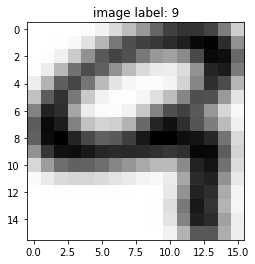

In [5]:
sample_index = 88

plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])

### Training the neural network

In [6]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(16*16, 10)# Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs):
        outputs = F.softmax(self.l1(inputs), dim=1)# Use softmax as the activation function for the last layer
        
        return outputs

In [7]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [8]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [9]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0896
Epoch [2/10], Loss: 0.0857
Epoch [3/10], Loss: 0.0816
Epoch [4/10], Loss: 0.0783
Epoch [5/10], Loss: 0.0755
Epoch [6/10], Loss: 0.0730
Epoch [7/10], Loss: 0.0707
Epoch [8/10], Loss: 0.0685
Epoch [9/10], Loss: 0.0664
Epoch [10/10], Loss: 0.0644


Text(0.5, 1.0, 'Visualization of convergence')

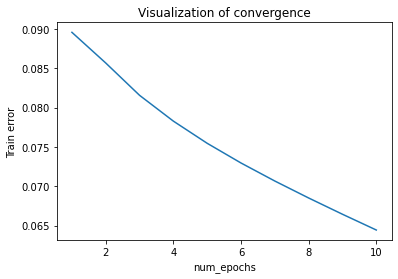

In [10]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [11]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [12]:
accuracy(val_set, model)

Accuracy of the model : 55.85 %


Text(0.5, 1.0, 'Prediction label: 1')

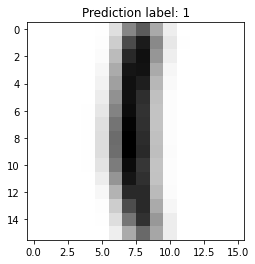

In [13]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

### Define a convolution neural network classifier

In [31]:
# define a function for training
# Calculate the accuracy to evaluate the model
def accuracy_conv(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))
    return 100*correct.item()/ len(dataset)
def train_conv(model, dataset = dataset , val_set = val_set , lr = 0.01 , num_epochs=10, batch_size=10, criterion=nn.MSELoss(), optimizer = torch.optim.SGD):
    train_error = []
    optimizer = optimizer(model.parameters(), lr=lr)

    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.float()) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
           
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(len(labels.numpy()), 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
        acc = accuracy_conv(val_set, model)
    return train_error , acc

In [15]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super (ConvBlock,self).__init__()
        self.module = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
    def forward(self,x):
        return self.module(x)

class Model(nn.Module):

    def __init__(self,n_convolutions=1,n_hidden=20,activation='relu'):

        super(Model,self).__init__()

        self.cnn= nn.Sequential()

        if activation == 'relu': self.act = nn.ReLU()
        elif activation == 'sigmoid' : self.act = nn.Sigmoid()
        elif activation == 'tanh'  : self.act = nn.Tanh()

        else: print ("NOT A VALID ACTIVATION")



        for i in range(n_convolutions):
            if i ==0:  self.cnn.add_module("convblock"+str(i),ConvBlock(1,5))
            else: self.cnn.add_module("convblock"+str(i),ConvBlock(5,5))
        
        self.cnn.add_module("flat",nn.Flatten(start_dim=1))
        
        self.commun = nn.Sequential(
                   self.cnn,
                  
             nn.Linear(self.cnn_out_size(),10),
            
         )
        
        
            
    def forward(self,x):
        
        commun_out = self.commun(x)
        predic = F.softmax(commun_out,dim=1)

        return predic


    def cnn_out_size(self):
        tst = torch.ones((1,1,16,16))
        return self.cnn(tst).size(-1)


m = Model(activation='relu')
m.cnn_out_size()

320

In [32]:
trial = {'models':[],'train_errors':[],'acc':[]}
for i in range(3):
    model = Model(n_convolutions=i,n_hidden=0)
    train_error ,acc = train_conv(model , num_epochs=20 , batch_size=10 )
    
    trial['models'].append(model)
    trial['train_errors'].append(train_error)
    trial['acc'].append(acc)

Epoch [1/20], Loss: 0.0884
Accuracy of the model : 21.92 %
Epoch [2/20], Loss: 0.0840
Accuracy of the model : 27.73 %
Epoch [3/20], Loss: 0.0805
Accuracy of the model : 39.58 %
Epoch [4/20], Loss: 0.0773
Accuracy of the model : 44.46 %
Epoch [5/20], Loss: 0.0740
Accuracy of the model : 47.79 %
Epoch [6/20], Loss: 0.0707
Accuracy of the model : 53.21 %
Epoch [7/20], Loss: 0.0674
Accuracy of the model : 58.64 %
Epoch [8/20], Loss: 0.0645
Accuracy of the model : 62.74 %
Epoch [9/20], Loss: 0.0617
Accuracy of the model : 65.30 %
Epoch [10/20], Loss: 0.0592
Accuracy of the model : 67.08 %
Epoch [11/20], Loss: 0.0568
Accuracy of the model : 68.32 %
Epoch [12/20], Loss: 0.0545
Accuracy of the model : 68.78 %
Epoch [13/20], Loss: 0.0526
Accuracy of the model : 69.71 %
Epoch [14/20], Loss: 0.0507
Accuracy of the model : 70.80 %
Epoch [15/20], Loss: 0.0490
Accuracy of the model : 72.04 %
Epoch [16/20], Loss: 0.0474
Accuracy of the model : 72.81 %
Epoch [17/20], Loss: 0.0460
Accuracy of the model

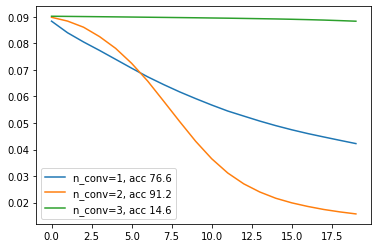

In [33]:
for i,error in enumerate(trial['train_errors']):

    acc = str(round(trial['acc'][i],1))
    plt.plot(error,label="n_conv="+str(i+1)+", acc "+acc)
    plt.legend()
    
plt.show()


In [34]:
class ConvBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super (ConvBlock,self).__init__()
        self.module = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
    def forward(self,x):
        return self.module(x)

class Model_withMLP(nn.Module):

    def __init__(self,n_hidden,n_convolutions=1,activation='relu'):

        super(Model_withMLP,self).__init__()
        self.n_hidden=n_hidden
        self.cnn= nn.Sequential()

        if activation == 'relu': self.act = nn.ReLU()
        elif activation == 'sigmoid' : self.act = nn.Sigmoid()
        elif activation == 'tanh'  : self.act = nn.Tanh()

        else: print ("NOT A FUCKING ACTIVATION")



        for i in range(n_convolutions):
            if i ==0:  self.cnn.add_module("convblock"+str(i),ConvBlock(1,5))
            else: self.cnn.add_module("convblock"+str(i),ConvBlock(5,5))
        
        self.cnn.add_module("flat",nn.Flatten(start_dim=1))
        
        if self.n_hidden==0:
              self.commun = nn.Sequential(
                        self.cnn,
                        
                  nn.Linear(self.cnn_out_size(),10),
                  
              )
        else : 
              self.commun = nn.Sequential(
                        self.cnn,
                  nn.Linear(self.cnn_out_size(),self.n_hidden),
                  self.act,      
                  nn.Linear(self.n_hidden,10),
                  
              )
        
        
            
    def forward(self,x):
        
        commun_out = self.commun(x)
        predic = F.softmax(commun_out,dim=1)

        return predic


    def cnn_out_size(self):
        tst = torch.ones((1,1,16,16))
        return self.cnn(tst).size(-1)


m = Model(activation='relu')
m.cnn_out_size()

320

In [35]:
trial2 = {'models':[],'train_errors':[],'acc':[]}
hiddens = [10,20,50,100]
for n_hidden in hiddens:
    model = Model_withMLP(n_convolutions=1,n_hidden=n_hidden)
    train_error , acc = train_conv(model , batch_size=10)
   
    trial2['models'].append(model)
    trial2['train_errors'].append(train_error)
    trial2['acc'].append(acc)



Epoch [1/10], Loss: 0.0910
Accuracy of the model : 8.29 %
Epoch [2/10], Loss: 0.0910
Accuracy of the model : 8.29 %
Epoch [3/10], Loss: 0.0909
Accuracy of the model : 8.29 %
Epoch [4/10], Loss: 0.0908
Accuracy of the model : 8.29 %
Epoch [5/10], Loss: 0.0908
Accuracy of the model : 8.29 %
Epoch [6/10], Loss: 0.0907
Accuracy of the model : 8.29 %
Epoch [7/10], Loss: 0.0907
Accuracy of the model : 8.29 %
Epoch [8/10], Loss: 0.0906
Accuracy of the model : 8.29 %
Epoch [9/10], Loss: 0.0905
Accuracy of the model : 8.29 %
Epoch [10/10], Loss: 0.0905
Accuracy of the model : 8.29 %
Epoch [1/10], Loss: 0.0904
Accuracy of the model : 15.26 %
Epoch [2/10], Loss: 0.0902
Accuracy of the model : 15.26 %
Epoch [3/10], Loss: 0.0900
Accuracy of the model : 15.26 %
Epoch [4/10], Loss: 0.0898
Accuracy of the model : 15.26 %
Epoch [5/10], Loss: 0.0896
Accuracy of the model : 15.26 %
Epoch [6/10], Loss: 0.0895
Accuracy of the model : 15.26 %
Epoch [7/10], Loss: 0.0893
Accuracy of the model : 15.26 %
Epoch 

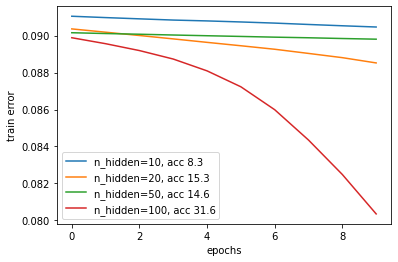

In [36]:
for i,n_hidden in enumerate(hiddens):

    acc = str(round(trial2['acc'][i],1))
    error = trial2['train_errors'][i]
    plt.plot(error,label="n_hidden="+str(n_hidden)+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt
    plt.legend()
    
plt.show()

In [37]:
trialx = {'models':[],'train_errors':[],'acc':[]}
acts = ['tanh','relu','sigmoid']
for act in acts:
    model = Model_withMLP(n_convolutions=1,n_hidden=100 , activation=act)
    train_error , acc = train_conv(model , batch_size=10 )
    trialx['models'].append(model)
    trialx['train_errors'].append(train_error)
    trialx['acc'].append(acc)


Epoch [1/10], Loss: 0.0900
Accuracy of the model : 7.13 %
Epoch [2/10], Loss: 0.0898
Accuracy of the model : 19.83 %
Epoch [3/10], Loss: 0.0895
Accuracy of the model : 15.26 %
Epoch [4/10], Loss: 0.0892
Accuracy of the model : 14.56 %
Epoch [5/10], Loss: 0.0887
Accuracy of the model : 14.56 %
Epoch [6/10], Loss: 0.0882
Accuracy of the model : 14.56 %
Epoch [7/10], Loss: 0.0875
Accuracy of the model : 14.56 %
Epoch [8/10], Loss: 0.0867
Accuracy of the model : 14.56 %
Epoch [9/10], Loss: 0.0857
Accuracy of the model : 28.89 %
Epoch [10/10], Loss: 0.0843
Accuracy of the model : 29.82 %
Epoch [1/10], Loss: 0.0904
Accuracy of the model : 4.65 %
Epoch [2/10], Loss: 0.0903
Accuracy of the model : 4.49 %
Epoch [3/10], Loss: 0.0901
Accuracy of the model : 9.06 %
Epoch [4/10], Loss: 0.0900
Accuracy of the model : 14.64 %
Epoch [5/10], Loss: 0.0898
Accuracy of the model : 14.56 %
Epoch [6/10], Loss: 0.0897
Accuracy of the model : 14.56 %
Epoch [7/10], Loss: 0.0895
Accuracy of the model : 14.56 %


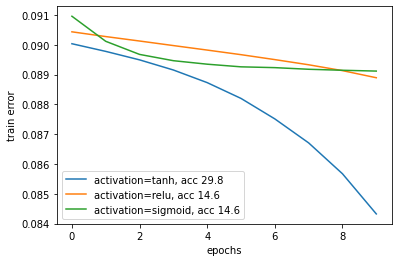

In [38]:
for i,act in enumerate(acts):

    acc = str(round(trialx['acc'][i],1))
    error = trialx['train_errors'][i]
    plt.plot(error,label="activation="+act+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt
    plt.legend()
    
plt.show()

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

In [39]:
trial3 = {'models':[],'train_errors':[],'acc':[]}
batch_sizes = [200, 100,50,10, 5]
for b_size in batch_sizes:
    model = Model_withMLP(n_convolutions=1,n_hidden=100 )
    train_error , acc = train_conv(model , batch_size=b_size  )
    trial3['models'].append(model)
    trial3['train_errors'].append(train_error)
    trial3['acc'].append(acc)

Epoch [1/10], Loss: 0.0912
Accuracy of the model : 15.34 %
Epoch [2/10], Loss: 0.0912
Accuracy of the model : 15.34 %
Epoch [3/10], Loss: 0.0911
Accuracy of the model : 15.34 %
Epoch [4/10], Loss: 0.0911
Accuracy of the model : 15.34 %
Epoch [5/10], Loss: 0.0911
Accuracy of the model : 15.34 %
Epoch [6/10], Loss: 0.0911
Accuracy of the model : 15.34 %
Epoch [7/10], Loss: 0.0911
Accuracy of the model : 15.26 %
Epoch [8/10], Loss: 0.0911
Accuracy of the model : 15.41 %
Epoch [9/10], Loss: 0.0911
Accuracy of the model : 15.41 %
Epoch [10/10], Loss: 0.0911
Accuracy of the model : 15.41 %
Epoch [1/10], Loss: 0.0903
Accuracy of the model : 8.83 %
Epoch [2/10], Loss: 0.0903
Accuracy of the model : 8.75 %
Epoch [3/10], Loss: 0.0903
Accuracy of the model : 8.75 %
Epoch [4/10], Loss: 0.0902
Accuracy of the model : 8.75 %
Epoch [5/10], Loss: 0.0902
Accuracy of the model : 8.75 %
Epoch [6/10], Loss: 0.0902
Accuracy of the model : 8.75 %
Epoch [7/10], Loss: 0.0901
Accuracy of the model : 8.68 %
Epo

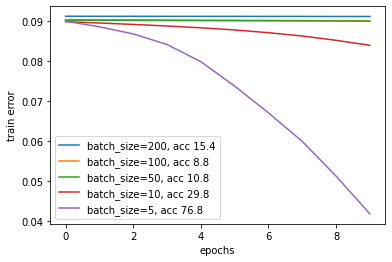

In [40]:
for i,b_size in enumerate(batch_sizes):

    acc = str(round(trial3['acc'][i],1))
    error = trial3['train_errors'][i]
    plt.plot(error,label="batch_size="+str(b_size)+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt
    plt.legend()
    
plt.show()

In [41]:
trial3 = {'models':[],'train_errors':[],'acc':[]}
lr_rates = [1e-4,1e-3,1e-2,1e-1,1,10]

for lr in lr_rates:
    model = Model_withMLP(n_convolutions=1,n_hidden=100 )
    train_error , acc = train_conv(model , batch_size=10 , lr = lr  )
    trial3['models'].append(model)
    trial3['train_errors'].append(train_error)
    trial3['acc'].append(acc)

Epoch [1/10], Loss: 0.0903
Accuracy of the model : 5.81 %
Epoch [2/10], Loss: 0.0903
Accuracy of the model : 5.89 %
Epoch [3/10], Loss: 0.0903
Accuracy of the model : 5.89 %
Epoch [4/10], Loss: 0.0903
Accuracy of the model : 5.89 %
Epoch [5/10], Loss: 0.0903
Accuracy of the model : 5.81 %
Epoch [6/10], Loss: 0.0903
Accuracy of the model : 5.89 %
Epoch [7/10], Loss: 0.0903
Accuracy of the model : 5.81 %
Epoch [8/10], Loss: 0.0903
Accuracy of the model : 5.65 %
Epoch [9/10], Loss: 0.0903
Accuracy of the model : 5.58 %
Epoch [10/10], Loss: 0.0903
Accuracy of the model : 5.58 %
Epoch [1/10], Loss: 0.0902
Accuracy of the model : 10.38 %
Epoch [2/10], Loss: 0.0902
Accuracy of the model : 10.38 %
Epoch [3/10], Loss: 0.0902
Accuracy of the model : 10.38 %
Epoch [4/10], Loss: 0.0902
Accuracy of the model : 10.38 %
Epoch [5/10], Loss: 0.0901
Accuracy of the model : 10.38 %
Epoch [6/10], Loss: 0.0901
Accuracy of the model : 10.38 %
Epoch [7/10], Loss: 0.0901
Accuracy of the model : 10.38 %
Epoch 

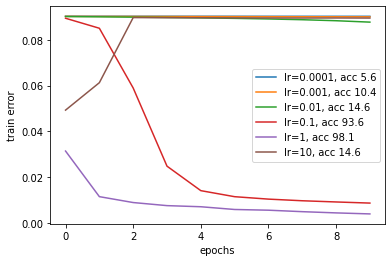

In [42]:
for i,lr in enumerate(lr_rates):

    acc = str(round(trial3['acc'][i],1))
    error = trial3['train_errors'][i]
    plt.plot(error,label="lr="+str(lr)+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    
plt.show()

In [43]:
trial3 = {'models':[],'train_errors':[],'acc':[]}
from torch.optim import SGD,RMSprop,Adam


opts_str = ['Adam','RMSprop','SGD']

for opt_str in opts_str:

    
    if opt_str == 'SGD': 
      opt = torch.optim.SGD
      LR =  0.1
    if opt_str == 'RMSprop' : 
      opt = torch.optim.RMSprop
      LR = .001
    if opt_str == 'Adam' : 
      opt=torch.optim.Adam
      LR = .001
    
    model = Model_withMLP(n_convolutions=1,n_hidden=100 )
    train_error , acc = train_conv(model , batch_size=10 , num_epochs =20 , lr = LR  , optimizer = opt)
    trial3['models'].append(model)
    trial3['train_errors'].append(train_error)
    trial3['acc'].append(acc)

Epoch [1/20], Loss: 0.0237
Accuracy of the model : 93.03 %
Epoch [2/20], Loss: 0.0096
Accuracy of the model : 93.88 %
Epoch [3/20], Loss: 0.0081
Accuracy of the model : 94.50 %
Epoch [4/20], Loss: 0.0069
Accuracy of the model : 96.59 %
Epoch [5/20], Loss: 0.0058
Accuracy of the model : 96.59 %
Epoch [6/20], Loss: 0.0051
Accuracy of the model : 96.98 %
Epoch [7/20], Loss: 0.0045
Accuracy of the model : 97.75 %
Epoch [8/20], Loss: 0.0041
Accuracy of the model : 97.99 %
Epoch [9/20], Loss: 0.0033
Accuracy of the model : 97.99 %
Epoch [10/20], Loss: 0.0030
Accuracy of the model : 98.06 %
Epoch [11/20], Loss: 0.0025
Accuracy of the model : 98.84 %
Epoch [12/20], Loss: 0.0022
Accuracy of the model : 98.84 %
Epoch [13/20], Loss: 0.0020
Accuracy of the model : 99.23 %
Epoch [14/20], Loss: 0.0018
Accuracy of the model : 98.53 %
Epoch [15/20], Loss: 0.0015
Accuracy of the model : 98.92 %
Epoch [16/20], Loss: 0.0015
Accuracy of the model : 99.46 %
Epoch [17/20], Loss: 0.0013
Accuracy of the model

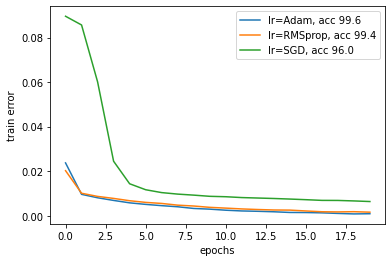

In [44]:
for i,opt in enumerate(opts_str):

    acc = str(round(trial3['acc'][i],1))
    error = trial3['train_errors'][i]
    plt.plot(error,label="lr="+opt+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    
plt.show()

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [45]:
class Model_withMLPCE(nn.Module):

    def __init__(self,n_hidden,n_convolutions=1,activation='relu'):

        super(Model_withMLPCE,self).__init__()
        self.n_hidden=n_hidden
        self.cnn= nn.Sequential()

        if activation == 'relu': self.act = nn.ReLU()
        elif activation == 'sigmoid' : self.act = nn.Sigmoid()
        elif activation == 'tanh'  : self.act = nn.Tanh()

        else: print ("NOT A VALID ACTIVATION")



        for i in range(n_convolutions):
            if i ==0:  self.cnn.add_module("convblock"+str(i),ConvBlock(1,5))
            else: self.cnn.add_module("convblock"+str(i),ConvBlock(5,5))
        
        self.cnn.add_module("flat",nn.Flatten(start_dim=1))
        
        if self.n_hidden==0:
              self.commun = nn.Sequential(
                        self.cnn,
                        
                  nn.Linear(self.cnn_out_size(),10),
                  
              )
        else : 
              self.CNN = nn.Sequential(
                        self.cnn,
                  nn.Linear(self.cnn_out_size(),self.n_hidden),
                  self.act,      
                  nn.Linear(self.n_hidden,10),
                  
              )
        
        
            
    def forward(self,x):
        
        predic = self.CNN(x)
        
        return predic


    def cnn_out_size(self):
        tst = torch.ones((1,1,16,16))
        return self.cnn(tst).size(-1)

In [46]:
def train_CE(model, dataset = dataset , val_set = val_set , lr = 0.01 , num_epochs=10, batch_size=5, criterion=nn.CrossEntropyLoss(), optimizer = torch.optim.SGD):
    train_error = []
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.float()) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            # labels_one_hot = torch.FloatTensor(batch_size, 10)
            # labels_one_hot.zero_()
            # labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            # print('Ypred' , y_pre.size())
            # print('Y' , labels_one_hot.size())
            loss = criterion(y_pre, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
        acc = accuracy_conv(val_set, model)
    return train_error , acc

In [47]:
trial3 = {'models':[],'train_errors':[],'acc':[]}
from torch.optim import SGD,RMSprop,Adam


opts_str = ['SGD','RMSprop','Adam']

for opt_str in opts_str:

    
    if opt_str == 'SGD': opt = torch.optim.SGD
    if opt_str == 'RMSprop' : opt = torch.optim.RMSprop
    if opt_str == 'Adam' : opt=torch.optim.Adam
    
    model = Model_withMLPCE(n_convolutions=1,n_hidden=100 )
    train_error , acc = train_CE(model , batch_size=10 , num_epochs =20 , lr = 0.01  , optimizer = opt)
    trial3['models'].append(model)
    trial3['train_errors'].append(train_error)
    trial3['acc'].append(acc)

Epoch [1/20], Loss: 1.8151
Accuracy of the model : 82.96 %
Epoch [2/20], Loss: 0.3850
Accuracy of the model : 67.00 %
Epoch [3/20], Loss: 0.2653
Accuracy of the model : 92.56 %
Epoch [4/20], Loss: 0.2268
Accuracy of the model : 92.41 %
Epoch [5/20], Loss: 0.2036
Accuracy of the model : 94.27 %
Epoch [6/20], Loss: 0.1856
Accuracy of the model : 95.20 %
Epoch [7/20], Loss: 0.1681
Accuracy of the model : 93.96 %
Epoch [8/20], Loss: 0.1581
Accuracy of the model : 95.66 %
Epoch [9/20], Loss: 0.1433
Accuracy of the model : 95.27 %
Epoch [10/20], Loss: 0.1359
Accuracy of the model : 94.42 %
Epoch [11/20], Loss: 0.1260
Accuracy of the model : 95.66 %
Epoch [12/20], Loss: 0.1156
Accuracy of the model : 96.75 %
Epoch [13/20], Loss: 0.1109
Accuracy of the model : 96.75 %
Epoch [14/20], Loss: 0.1013
Accuracy of the model : 97.13 %
Epoch [15/20], Loss: 0.0976
Accuracy of the model : 97.29 %
Epoch [16/20], Loss: 0.0930
Accuracy of the model : 96.98 %
Epoch [17/20], Loss: 0.0874
Accuracy of the model

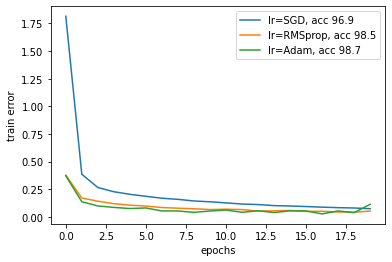

In [48]:
for i,opt in enumerate(opts_str):

    acc = str(round(trial3['acc'][i],1))
    error = trial3['train_errors'][i]
    plt.plot(error,label="lr="+opt+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    
plt.show()

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [49]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [50]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [51]:
opt = torch.optim.RMSprop
    
model = Model_withMLPCE(n_convolutions=1,n_hidden=100 )
train_error , acc = train_CE(model , batch_size=10 , num_epochs =20 , lr = 0.01  , optimizer = opt)

accuracy_conv(test_set, model)

Epoch [1/20], Loss: 0.4394
Accuracy of the model : 94.58 %
Epoch [2/20], Loss: 0.1928
Accuracy of the model : 95.82 %
Epoch [3/20], Loss: 0.1606
Accuracy of the model : 96.44 %
Epoch [4/20], Loss: 0.1302
Accuracy of the model : 97.13 %
Epoch [5/20], Loss: 0.1175
Accuracy of the model : 96.67 %
Epoch [6/20], Loss: 0.1006
Accuracy of the model : 97.06 %
Epoch [7/20], Loss: 0.1039
Accuracy of the model : 97.83 %
Epoch [8/20], Loss: 0.0889
Accuracy of the model : 98.68 %
Epoch [9/20], Loss: 0.0818
Accuracy of the model : 97.68 %
Epoch [10/20], Loss: 0.0763
Accuracy of the model : 97.29 %
Epoch [11/20], Loss: 0.0707
Accuracy of the model : 96.51 %
Epoch [12/20], Loss: 0.0667
Accuracy of the model : 98.06 %
Epoch [13/20], Loss: 0.0704
Accuracy of the model : 98.84 %
Epoch [14/20], Loss: 0.0622
Accuracy of the model : 97.99 %
Epoch [15/20], Loss: 0.0594
Accuracy of the model : 99.30 %
Epoch [16/20], Loss: 0.0594
Accuracy of the model : 98.99 %
Epoch [17/20], Loss: 0.0530
Accuracy of the model

93.02441454907823